# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pickle
from typing import Sequence
from tempfile import mkdtemp

import pandas as pd

from sklearn.pipeline import Pipeline

from src.io import CsvDataLoader, PickleLoader
from src.preproc import RawDataCleaner, TextCleaner, SimpleTokenizer

pd.set_option('display.max_rows', 100)

# load raw data & preprocess

In [114]:
pipe = Pipeline([
    ('load_data', CsvDataLoader(file_name='polish_sentiment_dataset.csv')),
    ('basic_cleaning', RawDataCleaner()),
    ('text_cleaning', TextCleaner()),
    ('tokenizer', SimpleTokenizer())
], memory=mkdtemp())

In [250]:
data = pipe.fit_transform(None)

/home/mic/Pulpit/pyProj/gensim/venv/lib/python3.8/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 2.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/home/mic/Pulpit/pyProj/gensim/venv/lib/python3.8/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 2.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they

In [ ]:
with open('./data/data_preproc.pkl', 'wb') as f:
    pickle.dump(data, f)

# basic eda

In [140]:
data.shape

(917525, 8)

In [141]:
data['negative'].value_counts(dropna=False)/len(data)

0.0    0.800228
1.0    0.199772
Name: negative, dtype: float64

<AxesSubplot:ylabel='Frequency'>

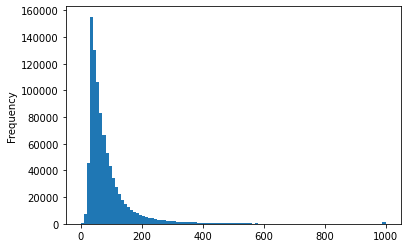

In [58]:
data['len'].clip(upper=1000).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

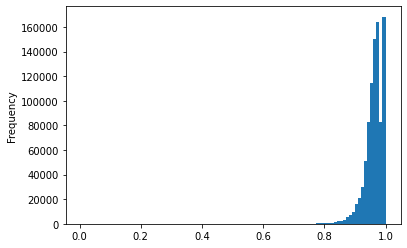

In [61]:
data['len_clean_ratio'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

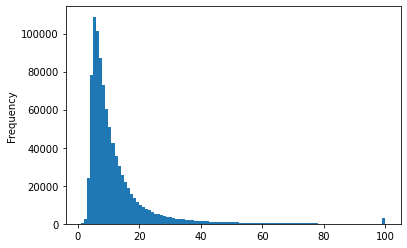

In [219]:
data['tokens_len'].clip(upper=100).plot.hist(bins=100)

## token length

In [ ]:
tokens_len = [(i, len(tok)) for i, toks in enumerate(data['tokens']) for tok in toks]
tokens_len = pd.DataFrame(tokens_len, columns=['row', 'tok_len'])

In [286]:
print(f"words in data: {len(tokens_len)}")

words in data: 12083288


<AxesSubplot:ylabel='Frequency'>

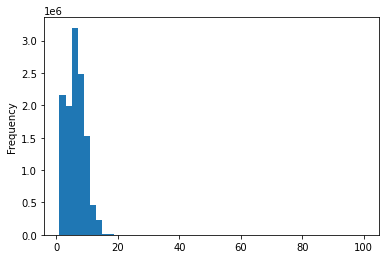

In [256]:
tokens_len['tok_len'].clip(upper=100).plot.hist(bins=50)

In [257]:
tokens_len['tok_len'].describe()

count    1.208329e+07
mean     5.755617e+00
std      4.244786e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      9.982000e+03
Name: tok_len, dtype: float64

In [258]:
max(tokens_len['tok_len'])

9982

In [271]:
tokens_len[tokens_len['tok_len']==50]

,row,tok_len
9940205,774921,50
10279304,812174,50
11840864,907920,50


In [261]:
data.index

RangeIndex(start=0, stop=917525, step=1)

In [274]:
data['desc_clean'][774921]

'xdxdxdxdxdxxxxxxxxxxxxxddddddddddddddxxxxxxxxxddxx'

# adhoc eda

In [226]:
data

(1, 1, 1, 1, 1, 1)

## lettes dict

In [8]:
from collections import Counter

def count_chars(s, chars):
    counter = Counter(s)
    return {c : counter.get(c,0) for c in chars}

letters_dict = Counter([c for s in data['desc'] for c in s])

In [9]:
sorted(letters_dict.items(), key=lambda i: i[1], reverse=True)

[(' ', 11269150),
 ('a', 6918402),
 ('e', 5827493),
 ('o', 5432923),
 ('i', 4519406),
 ('z', 4060100),
 ('n', 3448487),
 ('s', 3133460),
 ('r', 2971734),
 ('k', 2774425),
 ('y', 2761594),
 ('w', 2572928),
 ('t', 2412194),
 ('p', 2306489),
 ('m', 2204999),
 ('c', 2117288),
 ('d', 2068713),
 ('l', 1826311),
 ('b', 1633695),
 ('u', 1422661),
 ('j', 1374134),
 ('.', 1076430),
 ('ł', 1008407),
 (',', 807210),
 ('g', 713406),
 ('ó', 465146),
 ('ę', 448375),
 ('ż', 416814),
 ('P', 367068),
 ('ą', 360837),
 ('h', 338778),
 ('S', 288760),
 ('!', 278291),
 ('ś', 273548),
 ('f', 228596),
 ('\r', 219740),
 ('ć', 212443),
 ('B', 174693),
 ('A', 170350),
 ('W', 166578),
 ('O', 155386),
 ('D', 154107),
 ('T', 147638),
 ('Z', 133755),
 ('J', 133418),
 ('E', 132228),
 ('N', 122486),
 ('K', 104327),
 ('\n', 104190),
 ('M', 102931),
 (')', 99456),
 ('C', 95883),
 ('I', 91000),
 ('-', 84443),
 ('0', 83453),
 ('R', 82176),
 (':', 75159),
 ('L', 61472),
 ('ń', 60901),
 ('1', 58551),
 ('G', 48068),
 ('Y', 40

In [ ]:
# todo: \r, \n, \xa0 to space

## filter alpha num and punctuation

In [49]:
a = '257 najlepszy moment ψψ'
b = 'اغلاق الكلبة العربي يمارس الجنس مع ما يصل'
c = "stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?"
d = 'Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"'
e = '  asd  asd  '
f = 'łączńie ćma grzegżźółka'
g = 'Bardzo przyjazny klientom sklep. \\Realizuje, wszystkie zamówienai: takie - takie '
h = 'Szanowni Państwo, ODRADZAM !!!\r\r\r\n\r\r\r\n'
i = 'Szanowni Państwo,\r\r\r\n\r\r\r\n ODRADZAM !!!'
j = 'what???????!!!!!!!!!'

tt = [a,b,c,d,e,f,g,h,i,j]

In [25]:


for s in tt:
    c = re.sub(special, ' ', s)
    c = re.sub(alpha, '', c)
    c = re.sub('\s+', ' ', c)
    c = c.strip()
    print(f"len: {len(c)}|{c}|")

len: 20|257 najlepszy moment|
len: 0||
len: 93|stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?|
len: 84|Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"|
len: 7|asd asd|
len: 23|łączńie ćma grzegżźółka|
len: 78|Bardzo przyjazny klientom sklep. Realizuje, wszystkie zamówienai takie - takie|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 20|what???????!!!!!!!!!|


## frequency of tokens

In [38]:
from collections import defaultdict

In [39]:
frequency = defaultdict(int)
for text in data['tokens']:
    for token in text:
        frequency[token] += 1

In [40]:
frequency

defaultdict(int,
            {'polecam': 315905,
             'nie': 172775,
             'pierwszy': 10598,
             'i': 398206,
             'ostatni': 3423,
             'raz': 28057,
             'bardzo': 252797,
             'dobra': 28714,
             'komunikacja': 3123,
             'sms': 2372,
             'telefoniczna': 1045,
             'zamówiony': 4361,
             'towar': 83812,
             'wysłany': 1749,
             'w': 315221,
             'terminie': 4839,
             'dobrze': 32991,
             'zabezpieczony': 3448,
             'ten': 26560,
             'sklep': 128962,
             'zakupy': 56549,
             'tym': 46192,
             'sklepie': 41588,
             'są': 20369,
             'dostępne': 1703,
             'części': 5887,
             'nawet': 13004,
             'do': 93989,
             'starszych': 154,
             'modeli': 285,
             'np': 2586,
             'lodówek': 14,
             'jestem': 78910,
           

In [41]:
sorted(frequency.items(), key = lambda kv: kv[1], reverse=True)

[('i', 398206),
 ('polecam', 315905),
 ('w', 315221),
 ('bardzo', 252797),
 ('z', 240630),
 ('szybka', 192250),
 ('na', 173409),
 ('nie', 172775),
 ('to', 139799),
 ('szybko', 132690),
 ('sklep', 128962),
 ('wszystko', 114579),
 ('jak', 111862),
 ('obsługa', 95065),
 ('do', 93989),
 ('się', 93382),
 ('towar', 83812),
 ('sprawnie', 80236),
 ('jestem', 78910),
 ('ceny', 77569),
 ('zamówienia', 76376),
 ('realizacja', 74926),
 ('super', 73526),
 ('jest', 68724),
 ('dostawa', 65171),
 ('wysyłka', 64225),
 ('a', 62856),
 ('bez', 62555),
 ('że', 59991),
 ('zakupy', 56549),
 ('o', 53872),
 ('zadowolona', 51508),
 ('za', 48569),
 ('po', 47569),
 ('co', 47237),
 ('tym', 46192),
 ('transakcja', 45102),
 ('kontakt', 45036),
 ('dobry', 44991),
 ('przesyłka', 43729),
 ('zgodny', 43048),
 ('opisem', 42400),
 ('sklepie', 41588),
 ('ale', 41165),
 ('tak', 36785),
 ('ze', 36246),
 ('zawsze', 35920),
 ('już', 34291),
 ('dobrze', 32991),
 ('od', 31796),
 ('ok', 31697),
 ('zamówienie', 30467),
 ('błyskawi

In [43]:
sorted(frequency.items(), key = lambda kv: kv[1], reverse=False)

[('półtłusty', 1),
 ('slladnikiem', 1),
 ('wyrównano', 1),
 ('przydługawa', 1),
 ('maaasą', 1),
 ('ciogwiazdkowym', 1),
 ('długotrwała', 1),
 ('smsai', 1),
 ('szyfrowany', 1),
 ('najważniejszę', 1),
 ('regital', 1),
 ('przeterminowaniem', 1),
 ('wyprzedawany', 1),
 ('odkręciłem', 1),
 ('sklepiem', 1),
 ('abroad', 1),
 ('oczymalam', 1),
 ('pczka', 1),
 ('zakoszony', 1),
 ('zamaiwane', 1),
 ('potłukł', 1),
 ('farmaceutyku', 1),
 ('wzmiankowaną', 1),
 ('przrebiegało', 1),
 ('plasterki', 1),
 ('przyśpieszające', 1),
 ('gojenie', 1),
 ('postrzałowe', 1),
 ('zagoiły', 1),
 ('realizicji', 1),
 ('dostareczania', 1),
 ('skleu', 1),
 ('napotkały', 1),
 ('skontktowała', 1),
 ('boe', 1),
 ('wanosci', 1),
 ('agencją', 1),
 ('odnosniebproduktow', 1),
 ('poszukiwaneho', 1),
 ('zadawlający', 1),
 ('kojazyc', 1),
 ('kosmetykiempolecam', 1),
 ('kolorystyczną', 1),
 ('zafowoleni', 1),
 ('interpersonalne', 1),
 ('sptekach', 1),
 ('pełeny', 1),
 ('luteina', 1),
 ('akupuy', 1),
 ('ppierwszy', 1),
 ('niedost

# load preprocessed pickle

In [3]:
data = PickleLoader().load()

INFO:2021-10-28 20:40:00:io:loading from pickle: ./data/20211026_225637/df_prepro.pkl
INFO:2021-10-28 20:40:05:io:loaded 917525 rows


In [30]:
data.head()

,desc,len,negative,desc_clean,len_clean,len_clean_ratio,tokens,tokens_len
0,Polecam nie pierwszy i nie ostatni raz!,39,0.0,polecam nie pierwszy i nie ostatni raz,38,0.974359,"[polecam, nie, pierwszy, i, nie, ostatni, raz]",7
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121,0.0,bardzo dobra komunikacja sms i telefoniczna za...,117,0.966942,"[bardzo, dobra, komunikacja, sms, i, telefonic...",16
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87,0.0,polecam zakupy w tym sklepie są dostępne częśc...,84,0.965517,"[polecam, zakupy, w, tym, sklepie, są, dostępn...",14
3,Jestem w pełni zadowolona z przebiegu transakcji,48,0.0,jestem w pełni zadowolona z przebiegu transakcji,48,1.000000,"[jestem, w, pełni, zadowolona, z, przebiegu, t...",7
4,Transakcja przebiegła błyskawicznie. Pełen pro...,86,0.0,transakcja przebiegła błyskawicznie pełen prof...,84,0.976744,"[transakcja, przebiegła, błyskawicznie, pełen,...",9


# modeling

## imports

In [7]:
import gensim
from gensim import corpora, models

## dictionary

In [8]:
# Create dictionary
dictionary = corpora.Dictionary(data['tokens'])

In [9]:
print(f"unique tokens count: {len(dictionary)}")

unique tokens count: 260521


In [94]:
dictionary.token2id['hej']

3051

In [105]:
dictionary[0]

'i'

In [110]:
dictionary.doc2bow(['takie', 'tam', 'tu', 'tam'])

[(129, 2), (1165, 1), (2545, 1)]

In [112]:
dictionary.doc2bow('takie ładne cośik'.split())

[(2545, 1), (8059, 1)]

In [122]:
# number token occurances
dictionary.cfs[dictionary.token2id['i']]

398206

In [123]:
# number of documents with this token
dictionary.dfs[dictionary.token2id['i']]

322975

In [124]:
import copy

In [205]:
d2 = copy.copy(dictionary)

In [197]:
d2.filter_extremes(no_below=50, no_above=0.3, keep_n=10000, keep_tokens=None)

INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:discarding 250521 tokens: [('i', 322975), ('polecam', 311848), ('lodówek', 14), ('szybę', 36), ('elastyczna', 51), ('wyrozumiała', 41), ('magiczne', 7), ('pomylono', 51), ('różowo', 8), ('wybrakowany', 25)]...
INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:keeping 10000 tokens which were in no less than 50 and no more than 275257 (=30.0%) documents
INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:resulting dictionary: Dictionary(10000 unique tokens: ['nie', 'ostatni', 'pierwszy', 'raz', 'bardzo']...)


In [198]:
len(d2)

10000

In [206]:
d2.filter_extremes(no_below=None, no_above=None, keep_n=None, keep_tokens=None)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [207]:
dd = {'a': None, 'b': None}
dd

{'a': None, 'b': None}

In [210]:
if dict():
    print('hi')

In [211]:
dict()

{}

## corpus to pd

In [152]:
import scipy as sp

In [199]:
l = [['nie', 'raz', 'dobrze', 'ten'], ['dobra', 'do']]
# l = [['nie', 'raz', 'dobrze', 'ten']]

corpus = [d2.doc2bow(t) for t in l]
corpus

[[(0, 1), (3, 1), (6, 1), (11, 1)], [(5, 1), (19, 1)]]

In [200]:
i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(corpus) for t in row))

In [201]:
mm = sp.sparse.coo_matrix((data, (i, j)), shape=(len(corpus), len(d2)))

In [202]:
pd.DataFrame.sparse.from_spmatrix(mm)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## corpus

In [178]:
corpus = [dictionary.doc2bow(tokens) for tokens in data['tokens']]

In [14]:
len(corpus)

917525

In [111]:
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [129]:
d2.items()

ItemsView(<gensim.corpora.dictionary.Dictionary object at 0x7f59d5407280>)

In [219]:
for x in tfidf[corpus][:20]:
    print(x)

[(0, 0.13595079358327705), (3, 0.5820688743040994), (6, 0.1847102734992555), (11, 0.7801251964616102)]
[(5, 0.5519210881824143), (19, 0.8338963439298314)]


# tfidf

In [179]:
tfidf = models.TfidfModel(corpus, smartirs='ntc')

INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:collecting document frequencies
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #10000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #20000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #30000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #40000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #50000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #60000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #70000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #80000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #90000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PR

In [183]:
tfidf2 = models.TfidfModel(dictionary=dictionary, smartirs='ntc')

In [203]:
tfidf3 = models.TfidfModel(dictionary=d2, smartirs='ntc')

In [87]:
aa = [(0, 0.459457157251916), (2, 0.8881999328135463)]

In [180]:
tfidf[dictionary.doc2bow('takie ładne cośik'.split())]

[(2545, 0.5834586599705951), (8059, 0.8121428397180619)]

In [181]:
tfidf2[dictionary.doc2bow('takie ładne cośik'.split())]

[(2545, 0.5834586599705951), (8059, 0.8121428397180619)]

In [204]:
tfidf3[d2.doc2bow('takie ładne cośik'.split())]

[(1970, 0.5834586599705951), (4630, 0.8121428397180619)]

In [86]:
tfidf[(0, 1), (1, 1)]

[(0, 0.459457157251916), (1, 0.8881999328135463)]

In [82]:
tfidf[dictionary.doc2bow('takie ładne coś'.split())]

[(619, 0.505178657383013),
 (2545, 0.5035334516797687),
 (8059, 0.7008912805593708)]

In [81]:
tfidf[dictionary.doc2bow('takie ładne coś coś'.split())]

[(619, 0.7603732142847507),
 (2545, 0.3789484606664178),
 (8059, 0.5274757237606572)]

In [17]:
# count vectorizer reprezentation
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [75]:
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [74]:
tfidf[corpus[0]]

[(0, 0.11502465340007656),
 (1, 0.4447199823065697),
 (2, 0.6162766796694312),
 (3, 0.49247428983038594),
 (4, 0.11888695562762791),
 (5, 0.3905527956380666)]

In [310]:
# tfidf vectorizer reprezentation
tfidf[corpus][0]

[(0, 0.11502465340007656),
 (1, 0.4447199823065697),
 (2, 0.6162766796694312),
 (3, 0.49247428983038594),
 (4, 0.11888695562762791),
 (5, 0.3905527956380666)]

In [315]:
[(dictionary[tok_id], tok_freq) for tok_id, tok_freq in tfidf[corpus][0]]

[('i', 0.11502465340007656),
 ('nie', 0.4447199823065697),
 ('ostatni', 0.6162766796694312),
 ('pierwszy', 0.49247428983038594),
 ('polecam', 0.11888695562762791),
 ('raz', 0.3905527956380666)]

In [316]:
[(dictionary[tok_id], tok_freq) for tok_id, tok_freq in tfidf[corpus][1]]

[('i', 0.060944159953105696),
 ('polecam', 0.06299054529559758),
 ('bardzo', 0.08280210917801677),
 ('dobra', 0.20322288487180415),
 ('dobrze', 0.19508840777884015),
 ('komunikacja', 0.3317832424818046),
 ('sklep', 0.11649578839171103),
 ('sms', 0.3497153161337092),
 ('telefoniczna', 0.39583410968622923),
 ('ten', 0.20909075076732328),
 ('terminie', 0.3069124397146287),
 ('towar', 0.1416645550082417),
 ('w', 0.07953541854259781),
 ('wysłany', 0.3676203764967229),
 ('zabezpieczony', 0.3259806243987228),
 ('zamówiony', 0.31264824437629013)]

# tfidf transformer

In [4]:
from src.nlp.tfidf import TfIdfTransformer

In [18]:
tfidf_model = TfIdfTransformer()

tfidf_model.fit(data['tokens'])

TypeError: __init__() got an unexpected keyword argument 'max_df'

In [6]:
tfidf_df = tfidf_model.transform(data['tokens'])

INFO:2021-10-28 20:49:14:tfidf:creating corpus, mem used: 22.7
INFO:2021-10-28 20:49:23:tfidf:vectorizing corpus with tfidf model, mem used: 27.1
INFO:2021-10-28 20:50:08:tfidf:creating sparse corpus representation, mem used: 33.6
INFO:2021-10-28 20:50:25:tfidf:creating sparse df, mem used: 39.0


In [8]:
tfidf_df.shape

(917525, 5000)

# tfidf sklearn model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from src.utils import mem_used

In [19]:
tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, min_df=5, max_features=5000))])

In [20]:
print(f"tfidf vectorizer start, mem used: {mem_used()}")
tfidf_mtrx = tfidf_pipe.fit_transform(data['desc_clean'])
print(f"tfidf vectorizer end, mem used: {mem_used()}")

tfidf vectorizer start, mem used: 28.0
tfidf vectorizer end, mem used: 28.5


In [21]:
print(f"sparse df start, mem used: {mem_used()}")
tfidf_df_sparse = pd.DataFrame.sparse.from_spmatrix(tfidf_mtrx, columns=tfidf_pipe.get_feature_names_out())
print(f"sparse df end, mem used: {mem_used()}")

sparse df start, mem used: 29.3
sparse df end, mem used: 27.8


In [22]:
tfidf_df_sparse.shape

(917525, 5000)

In [23]:
tfidf_pipe.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.5, max_features=5000, min_df=5))],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.5, max_features=5000, min_df=5),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None}

In [11]:
tfidf_sk_model.get_feature_names_out()

array(['00', '000', '0000', ..., 'żłówia', 'żźe', 'żże'], dtype=object)

# catboost

In [26]:
from catboost import CatBoostClassifier

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
data_train, data_test, y_train, y_test = train_test_split(
    data[['desc_clean']], data['negative'], test_size=0.33, random_state=12345)

## catboost on clean text

In [46]:
cb_params = {
    'eval_metric': 'AUC',
    'text_features': ['desc_clean'],
    'metric_period': 10,
    'verbose': 10,
}

In [48]:
cb1 = CatBoostClassifier(**cb_params)
cb1.fit(X=data_train, y=y_train, eval_set=(data_test, y_test))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.15478
0:	test: 0.9811921	best: 0.9811921 (0)	total: 249ms	remaining: 4m 8s
10:	test: 0.9981425	best: 0.9981425 (10)	total: 4.12s	remaining: 6m 10s
20:	test: 0.9984857	best: 0.9984857 (20)	total: 7.21s	remaining: 5m 36s
30:	test: 0.9986127	best: 0.9986127 (30)	total: 10s	remaining: 5m 13s
40:	test: 0.9986980	best: 0.9986980 (40)	total: 13s	remaining: 5m 4s
50:	test: 0.9987554	best: 0.9987554 (50)	total: 16.1s	remaining: 4m 59s
60:	test: 0.9987867	best: 0.9987867 (60)	total: 18.8s	remaining: 4m 49s
70:	test: 0.9988311	best: 0.9988311 (70)	total: 21.8s	remaining: 4m 45s
80:	test: 0.9988579	best: 0.9988579 (80)	total: 24.7s	remaining: 4m 39s
90:	test: 0.9988786	best: 0.9988786 (90)	total: 27.5s	remaining: 4m 34s
100:	test: 0.9988976	best: 0.9988976 (100)	total: 30.4s	remaining: 4m 30s
110:	test: 0.9989246	best: 0.9989246 (110)	total: 33.8s	remaining: 4m 30s
120:	test: 0.9989497	best: 0.9989497 (120)	total: 37.3s	remaining: 4m 30s
130:	test: 0.9989613	best: 0.9989613 

In [53]:
preds = cb1.predict_proba(data_test)
preds = [x[1] for x in preds]
preds

[2.1967404233243268e-05,
 0.00010487714335812502,
 0.9999040794649796,
 0.00012439837401918025,
 9.280813164507411e-05,
 3.800666082921923e-05,
 8.612237621514415e-05,
 0.00031603904215249043,
 0.00018175357230102137,
 9.572053693476256e-05,
 0.0001598442280958256,
 0.0002550774167934423,
 6.902618124834835e-05,
 0.0003582307536805876,
 0.0009486938394302476,
 2.7496494984407184e-05,
 0.0003063012056951605,
 0.00021579866700682332,
 8.833471503651925e-05,
 6.90365569768588e-05,
 0.00044248458242275297,
 0.03638029857896968,
 1.121274451491941e-05,
 6.970953952083376e-05,
 0.00047908647844876036,
 0.00479005421080683,
 0.0005089344551682088,
 0.9983187274760547,
 0.000841092087211224,
 2.309191955122913e-05,
 0.003016110703655278,
 0.00019055333086782176,
 0.00015880137088931985,
 0.00033595824937481287,
 0.0002583836569645943,
 0.00045689397793653583,
 0.993457828711941,
 3.832881061624575e-05,
 0.00035247049993952984,
 0.0005144591501940259,
 0.0006458350105219548,
 0.0005113407880836

In [59]:
X_test = pd.DataFrame(
    zip(data_test['desc_clean'], y_test, preds), 
    columns=['desc_clean', 'negative', 'pred'],
    index=data_test.index
)
X_test['pred_q10'] = pd.qcut(X_test['pred'], q=10, labels=False)

<AxesSubplot:xlabel='pred_q10'>

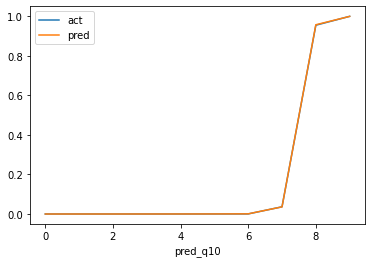

In [66]:
X_test.groupby('pred_q10').agg(
    act=('negative', 'mean'),
    pred=('pred', 'mean')
).plot()

In [70]:
len(data)

917525

In [73]:
len(pd.unique(data['desc']))

815161

In [69]:
len(pd.unique(data['desc_clean']))

760885

In [74]:
data['desc_clean'].value_counts()[:10]

transakcja przebiegła pomyślnie polecam       2537
wszystko w jak najlepszym porządku            2125
transakcja przebiegła pomyślnie               1913
wszystko w jak najlepszym porządku polecam    1122
wszystko w najlepszym porządku                 796
bardzo szybka realizacja zamówienia            686
wszystko w najlepszym porządku polecam         645
szybka realizacja zamówienia polecam           576
szybko sprawnie profesjonalnie                 543
wszystko szybko i sprawnie polecam             502
Name: desc_clean, dtype: int64

## catboost on deduplicated data

In [76]:
datau = data[['desc_clean', 'negative']].drop_duplicates()

In [77]:
data_trainu, data_testu, y_trainu, y_testu = train_test_split(
    datau[['desc_clean']], datau['negative'], test_size=0.33, random_state=12345)

In [ ]:
cb2 = CatBoostClassifier(**cb_params)
cb2.fit(X=data_trainu, y=y_trainu, eval_set=(data_testu, y_testu))

Learning rate set to 0.147787
0:	test: 0.9783498	best: 0.9783498 (0)	total: 212ms	remaining: 3m 31s
10:	test: 0.9977877	best: 0.9977877 (10)	total: 2.88s	remaining: 4m 19s
20:	test: 0.9982901	best: 0.9982901 (20)	total: 5.84s	remaining: 4m 32s
30:	test: 0.9984367	best: 0.9984367 (30)	total: 9.17s	remaining: 4m 46s
40:	test: 0.9985372	best: 0.9985372 (40)	total: 12s	remaining: 4m 39s
50:	test: 0.9985920	best: 0.9985920 (50)	total: 14.4s	remaining: 4m 28s
60:	test: 0.9986588	best: 0.9986588 (60)	total: 17.2s	remaining: 4m 24s
70:	test: 0.9987122	best: 0.9987122 (70)	total: 19.9s	remaining: 4m 20s
80:	test: 0.9987579	best: 0.9987579 (80)	total: 22.6s	remaining: 4m 15s
90:	test: 0.9987848	best: 0.9987848 (90)	total: 25.2s	remaining: 4m 11s
100:	test: 0.9988103	best: 0.9988103 (100)	total: 28s	remaining: 4m 9s
110:	test: 0.9988231	best: 0.9988231 (110)	total: 30.7s	remaining: 4m 6s
120:	test: 0.9988459	best: 0.9988459 (120)	total: 33.9s	remaining: 4m 5s
130:	test: 0.9988709	best: 0.9988709 

# catboost on tfidf

,desc,len,negative,desc_clean,len_clean,len_clean_ratio,tokens,tokens_len
0,Polecam nie pierwszy i nie ostatni raz!,39,0.0,polecam nie pierwszy i nie ostatni raz,38,0.974359,"[polecam, nie, pierwszy, i, nie, ostatni, raz]",7
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121,0.0,bardzo dobra komunikacja sms i telefoniczna za...,117,0.966942,"[bardzo, dobra, komunikacja, sms, i, telefonic...",16
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87,0.0,polecam zakupy w tym sklepie są dostępne częśc...,84,0.965517,"[polecam, zakupy, w, tym, sklepie, są, dostępn...",14
3,Jestem w pełni zadowolona z przebiegu transakcji,48,0.0,jestem w pełni zadowolona z przebiegu transakcji,48,1.000000,"[jestem, w, pełni, zadowolona, z, przebiegu, t...",7
4,Transakcja przebiegła błyskawicznie. Pełen pro...,86,0.0,transakcja przebiegła błyskawicznie pełen prof...,84,0.976744,"[transakcja, przebiegła, błyskawicznie, pełen,...",9
...,...,...,...,...,...,...,...,...
917520,Coraz lepiej wygląda,20,1.0,coraz lepiej wygląda,20,1.000000,"[coraz, lepiej, wygląda]",3
917521,JA SRAM NA TEN PIERSCIONEK I NA CIEBIE CHWILE ...,89,1.0,ja sram na ten pierscionek i na ciebie chwile ...,89,1.000000,"[ja, sram, na, ten, pierscionek, i, na, ciebie...",17
917522,Rafatus do Marleny Ty kurwo bez honoru ...,126,1.0,rafatus do marleny ty kurwo bez honoru kto tu ...,91,0.722222,"[rafatus, do, marleny, ty, kurwo, bez, honoru,...",16
917523,matka Marleny prosi o pomoc,29,1.0,matka marleny prosi o pomoc,27,0.931034,"[matka, marleny, prosi, o, pomoc]",5


# preproc and tokenize user sentence

In [33]:

from src.preproc import RawDataCleaner, TextCleaner, SimpleTokenizer

In [34]:
tokenizer = SimpleTokenizer()

In [35]:
tokenizer.tokenize('a co tam!')

['a', 'co', 'tam!']

# w2v

In [3]:
with open('./data/data_preproc.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
model

In [4]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=data['tokens'], vector_size=25, window=5, min_count=1, workers=4)
model.save("./models/word2vec.model")

FileNotFoundError: [Errno 2] No such file or directory: './models/word2vec.model'

In [6]:
from datetime import datetime

In [7]:
dateTimeObj = datetime.now()

In [8]:
print(dateTimeObj)

2021-10-25 23:07:27.035741


In [10]:
timestampStr = dateTimeObj.strftime("%Y%m%d_%H%M%S")
print(timestampStr)

20211025_230727


# test single sentence wrapper

# test single column transformers

In [63]:
a = '257 najlepszy moment ψψ'
b = 'اغلاق الكلبة العربي يمارس الجنس مع ما يصل'
c = "stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?"
d = 'Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"'
e = '  asd  asd  '
f = 'łączńie ćma grzegżźółka'
g = 'Bardzo przyjazny klientom sklep. \\Realizuje, wszystkie zamówienai: takie - takie '
h = 'Szanowni Państwo, ODRADZAM !!!\r\r\r\n\r\r\r\n'
i = 'Szanowni Państwo,\r\r\r\n\r\r\r\n ODRADZAM !!!'
j = 'what???????!!!!!!!!!'

tt = [a,b,c,d,e,f,g,h,i,j]

In [47]:
from src.preproc_columns import TextCleaner, SimpleTokenizer

In [58]:
TextCleaner().transform(tt)

['257 najlepszy moment',
 '',
 'stara sowiecka szkola zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac',
 'dobrze szkoda że inpost nie precyzuje co oznacza że dostarcza przesyłkę od rana',
 'asd asd',
 'łączńie ćma grzegżźółka',
 'bardzo przyjazny klientom sklep realizuje wszystkie zamówienai takie takie',
 'szanowni państwo odradzam',
 'szanowni państwo odradzam',
 'what']

In [61]:
TextCleaner().fit_transform(tt)

['257 najlepszy moment',
 '',
 'stara sowiecka szkola zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac',
 'dobrze szkoda że inpost nie precyzuje co oznacza że dostarcza przesyłkę od rana',
 'asd asd',
 'łączńie ćma grzegżźółka',
 'bardzo przyjazny klientom sklep realizuje wszystkie zamówienai takie takie',
 'szanowni państwo odradzam',
 'szanowni państwo odradzam',
 'what']

In [57]:
TextCleaner().transform('takie tam!??   oj 12')

'takie tam oj 12'

In [60]:
TextCleaner().fit_transform('takie tam!??   oj 12')

'takie tam oj 12'

In [67]:
prep_p = Pipeline([
    ('clean', TextCleaner()),
    ('tokenize', SimpleTokenizer())
])

In [70]:
prep_p.transform(tt)

[['257', 'najlepszy', 'moment'],
 [],
 ['stara',
  'sowiecka',
  'szkola',
  'zaczynam',
  'sie',
  'zastanawiac',
  'czy',
  'mozna',
  'by',
  'ich',
  'legalnie',
  'zdelegalizowac'],
 ['dobrze',
  'szkoda',
  'że',
  'inpost',
  'nie',
  'precyzuje',
  'co',
  'oznacza',
  'że',
  'dostarcza',
  'przesyłkę',
  'od',
  'rana'],
 ['asd', 'asd'],
 ['łączńie', 'ćma', 'grzegżźółka'],
 ['bardzo',
  'przyjazny',
  'klientom',
  'sklep',
  'realizuje',
  'wszystkie',
  'zamówienai',
  'takie',
  'takie'],
 ['szanowni', 'państwo', 'odradzam'],
 ['szanowni', 'państwo', 'odradzam'],
 ['what']]

# adhoc

In [52]:
for x in ['aaa']:
    print(x)

aaa


In [45]:
''.split()

[]

In [44]:
[1].copy()

[1]

In [ ]:
datasets = pd.DataFrame(columns=['id', 'ts', 'params', 'git_branch', 'git_commit', 'shape', 'columns'])

In [128]:
import os

os.mkdir('./data/test')

,a,b
0,1,2


In [138]:
aa = pd.DataFrame(columns=['c', 'd'])
aa.append(pd.Series((1,2)).to_frame().T)


,c,d,0,1
0,NaN,NaN,1.0,2.0


'./data/er'

In [141]:
with open('./data/20211026_020140/df_prepro_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [142]:
metadata

,ts,params,working_dir,git_branch,git_commit,git_sha,shape,columns
0,20211026_020140,{'load_data__file_name': 'polish_sentiment_dat...,/home/mic/Pulpit/pyProj/gensim,master,add prep_data.py modelue for running data prep...,5dbad2a69f2ea7004d30e2c21206c03d4bdfec36,"(917525, 8)","[desc, len, negative, desc_clean, len_clean, l..."
